### Import All Important Modules

In [1]:
import os
import re
import random
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import transformers
from copy import deepcopy
from collections import defaultdict
from urllib import request

from sklearn import metrics
from sklearn.utils import resample
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nlpaug.augmenter.word as naw

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from transformers import RobertaModel, RobertaTokenizer

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

logging.basicConfig(level=logging.ERROR)

# Ensure WordNet is downloaded for synonym replacement
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

device = 'cuda'
print(f'device: {device}')

device: cuda


[nltk_data] Downloading package wordnet to /homes/dj623/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /homes/dj623/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /homes/dj623/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /homes/dj623/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


#### Reproducibility

In [2]:
# Set random seed for reproducibility
import os
def set_random_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    
    # Set the random seed for torch and other libraries
    torch.manual_seed(seed)
    torch.backends.mps.deterministic = True  # Ensure deterministic behavior on MPS
    torch.backends.mps.benchmark = False  # Disable non-deterministic algorithms

    # If using CUDA (GPU), these would be important but since you're on MPS, they might be unused
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # For all GPUs
        torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior on CUDA
        torch.backends.cudnn.benchmark = False  # Disable non-deterministic algorithms

    # Ensure hash randomization is fixed in Python
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seeds(42)  # Set the random seed to 42 for reproducibility

* DontPatronizeMe class directly taken from the author's repo for importing the data correctly with 0,1 labels as Not PCL and 2,3,4 labels as PCL

In [4]:
class DontPatronizeMe:

	def __init__(self, train_path, test_path):

		self.train_path = train_path
		self.test_path = test_path
		self.train_task1_df = None
		self.train_task2_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels. 
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(os.path.join(self.train_path, 'dontpatronizeme_pcl.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		self.train_task1_df = df

	def load_task2(self, return_one_hot=True):
		# Reads the data for task 2 and present it as paragraphs with binarized labels (a list with seven positions, "activated or not (1 or 0)",
		# depending on wether the category is present in the paragraph).
		# It returns a pandas dataframe with paragraphs and list of binarized labels.
		tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
		print('Map of label to numerical label:')
		print(tag2id)
		data = defaultdict(list)
		with open (os.path.join(self.train_path, 'dontpatronizeme_categories.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				text=line.split('\t')[2]#.lower()
				keyword=line.split('\t')[3]
				country=line.split('\t')[4]
				start=line.split('\t')[5]
				finish=line.split('\t')[6]
				text_span=line.split('\t')[7]
				label=line.strip().split('\t')[-2]
				num_annotators=line.strip().split('\t')[-1]
				labelid = tag2id[label]
				if not labelid in data[(par_id, art_id, text, keyword, country)]:
					data[(par_id,art_id, text, keyword, country)].append(labelid)

		par_ids=[]
		art_ids=[]
		pars=[]
		keywords=[]
		countries=[]
		labels=[]

		for par_id, art_id, par, kw, co in data.keys():
			par_ids.append(par_id)
			art_ids.append(art_id)
			pars.append(par)
			keywords.append(kw)
			countries.append(co)

		for label in data.values():
			labels.append(label)

		if return_one_hot:
			labels = MultiLabelBinarizer().fit_transform(labels)
		df = pd.DataFrame(list(zip(par_ids, 
									art_ids, 
									pars, 
									keywords,
									countries, 
									labels)), columns=['par_id',
														'art_id', 
														'text', 
														'keyword',
														'country', 
														'label',
														])
		self.train_task2_df = df


	def load_test(self):
		#self.test_df = [line.strip() for line in open(self.test_path)]
		rows=[]
		with open(self.test_path) as f:
			for line in f:
				t=line.strip().split('\t')
				rows.append(t)
		self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())

### Data Preprocessing
* Additionally
    - Data Augmentation
    - Upsampling Strategies

In [7]:
class DataPreprocessing:
    def __init__(self):
        pass

    def load_train_data(self,data,train_ids):
        rows = [] # will contain par_id, label and text
        for idx in range(len(train_ids)):
            id = train_ids.par_id[idx]
            # select row from original dataset to retrieve `text` and binary label
            keyword = data.loc[data.par_id == id].keyword.values[0]
            text = data.loc[data.par_id == id].text.values[0]
            label = data.loc[data.par_id == id].label.values[0]
            country = data.loc[data.par_id == id].country.values[0]
        
            rows.append({
                'par_id':id,
                'keyword':keyword,
                'text':text,
                'country':country,
                'label':label
            })

        train_df = pd.DataFrame(rows)

        return train_df

    
    def load_dev_data(self,data,test_ids):
        rows = [] # will contain par_id, label and text
        for idx in range(len(test_ids)):
            parid = test_ids.par_id[idx]
            # select row from original dataset
            keyword = data.loc[data.par_id == parid].keyword.values[0]
            text = data.loc[data.par_id == parid].text.values[0]
            country = data.loc[data.par_id == parid].country.values[0]
            label = data.loc[data.par_id == parid].label.values[0]
            rows.append({
                'par_id':parid,
                'keyword':keyword,
                'text':text,
                'country':country,
                'label':label
            })

        dev_df = pd.DataFrame(rows)
        return dev_df
    
    def load_test_data(self, data):
        rows = []
        for idx in range(len(data)):
            parid = data.par_id[idx]
            keyword = data.keyword[idx]
            text = data.text[idx]
            country = data.country[idx]

            rows.append({
                'par_id': parid,
                'keyword': keyword,
                'text': text,
                'country': country
            })

        return pd.DataFrame(rows)
    

    def perform_train_sampling(self, train_df, sampling_strategy = "upsample_minority"):
        # downsample negative instances
        if sampling_strategy == "upsample_minority":
            pcldf = train_df[train_df.label==1]
            npos = len(pcldf)

            # Separate the classes
            pcl_df = train_df[train_df.label == 1]  # Minority class
            not_pcl_df = train_df[train_df.label == 0]  # Majority class

            # Oversample the minority class (PCL) to match the majority class size
            pcl_oversampled = resample(pcl_df,
                                    replace=True,  # Sample with replacement
                                    n_samples=len(not_pcl_df),  # Match the number of Not PCL examples
                                    random_state=42)  # For reproducibility

            # Combine the oversampled minority class with the majority class
            balanced_train_df = pd.concat([not_pcl_df, pcl_oversampled])
        elif sampling_strategy == "downsample_majority":
            balanced_train_df = pd.concat([pcldf, train_df[train_df.label==0][:int(2.5*npos)]])

        return balanced_train_df
    

    def augment_data(self,data,augmentation_type = "first"):
        # Define the augmenter using synonym replacement with WordNet
        aug = naw.SynonymAug(aug_src='wordnet')

        # Step 1: Identify PCL examples (label == 1) from balanced_train_df
        pcl_df = data[data['label'] == 1]

        # Step 2: Create a copy of PCL examples to augment
        augmented_pcl_df = pcl_df.copy()

        # Step 3: Apply augmentation to the 'text' column of the copied DataFrame
        # The lambda function applies augmentation to each text and takes the first result
        augmented_pcl_df['text'] = pcl_df['text'].apply(lambda x: aug.augment(x)[0])

        # Step 4: Combine the original data with the augmented PCL examples
        augmented_train_df = pd.concat([data, augmented_pcl_df], ignore_index=True)

        return augmented_train_df

        

    def load_data(self, sampling_strategy = "upsample_minority", augmentation = "first"):
        # Init data manager module
        # Full main data
        dpm = DontPatronizeMe('./NLP_CW24/data', './NLP_CW24/data/task4_test.tsv')
        dpm.load_task1()
        dpm.load_test()

        # Train and test splits
        train_ids = pd.read_csv('./NLP_CW24/data/train_semeval_parids-labels.csv')
        test_ids = pd.read_csv('./NLP_CW24/data/dev_semeval_parids-labels.csv')

        # Train and test ids
        train_ids.par_id = train_ids.par_id.astype(str)
        test_ids.par_id = test_ids.par_id.astype(str)

        data=dpm.train_task1_df

        train_df = self.load_train_data(data,train_ids)

        train_df = self.perform_train_sampling(train_df)

        train_df = train_df[['text', 'keyword', 'label', 'country']]

        augmented_train_df = self.augment_data(train_df)

        dev_df = self.load_dev_data(data,test_ids)

        test_df = self.load_test_data(dpm.test_set_df)  # Preprocess test set

        return augmented_train_df, dev_df, test_df

In [8]:
preprocessing = DataPreprocessing()
augmented_train_df, dev_df, test_df = preprocessing.load_data()

In [10]:
class DPMDataset(Dataset):
    """
    Dataset for regular use with Roberta/Deberta
    """

    def __init__(self, df, tokenizer, max_len, test_set=False):
        
        self.test_set = test_set
        self.tokenizer = tokenizer
        self.text = df.text

        if not test_set:
            self.label = df.label

        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):

        if not self.test_set:
            return {
                'text': self.text[idx],
                'target': self.label[idx]
            }
        else:
            return {
                'text': self.text[idx],
            }


    def collate_fn(self, batch):
        texts = []
        labels = []


        for b in batch:
            texts.append(b['text'])
            if not self.test_set:
                labels.append(b['target'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        if not self.test_set:
            encodings['target'] = torch.tensor(labels)

        return encodings

### Training Loop for PCL classification with base model as Deberta and additional Highway Network 

In [11]:
# TRAINING LOOP FOR TRAINING DEBERTA 
from transformers import Trainer, TrainingArguments, DebertaTokenizer, RobertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

class Trainer_PCL(Trainer):

    def __init__( 
        self,
        **kwargs
        ):

        super().__init__(**kwargs)
        
        self.epoch = 1
        self.results = {}


    def compute_loss(self, model, inputs, num_items_in_batch=None):
        
        outputs = model(**inputs)

        loss_fn = nn.CrossEntropyLoss()
        target = inputs['target']
        loss = loss_fn(outputs.view(-1, 2), target.view(-1))
        return loss
    
    # Custom Evaluation 
    def evaluate(self, evaluate_datset=None, ignore_keys=None, metric_key_prefix='eval'):
        
        if self.epoch < 10:
            self.epoch+=1
            return
        preds = []
        labels = []

        eval_dataloader = super().get_test_dataloader(self.eval_dataset)
        self.model.eval()
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                
                output = self.model(**data)
                pred = torch.max(output, 1)[1]
            
                preds.extend(pred.cpu().tolist())
                labels.extend(data['target'].cpu().tolist())

        metrics = compute_metrics((preds, labels))
        print(metrics)

        self.results[self.epoch] = metrics
        self.epoch += 1       

            
def compute_metrics(eval_pred):

    preds, labels = eval_pred

    report = classification_report(preds, labels, target_names=["Not PCL","PCL"], output_dict= True) 

    return {"f1": report['PCL']['f1-score'],"precision": report['PCL']['precision'],"recall": report['PCL']['recall']}

def train(model, data, num_epochs, lr=0.0001, optimizer=None, lr_scheduler=None, max_len=128):
    
    train_data, eval_data = train_test_split(data, test_size=0.2, random_state=1)

    # Reset the index for the training DataFrame
    train_data = train_data.reset_index(drop=True)
    # Reset the index for the evaluation DataFrame
    eval_data = eval_data.reset_index(drop=True)
    
    # tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')


    train_dataset = DPMDataset(train_data, tokenizer, max_len=128)
    eval_dataset = DPMDataset(eval_data, tokenizer, max_len=128)

    Training_args = TrainingArguments(output_dir="test_trainer",
                                    learning_rate=lr,
                                    logging_steps=100,
                                    per_device_train_batch_size=50,
                                    num_train_epochs=num_epochs,
                                    remove_unused_columns=False,
                                    logging_dir='./logs', 
                                    evaluation_strategy="epoch"
                                    )
    
    trainer = Trainer_PCL(
        model = model,
        args = Training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        data_collator= train_dataset.collate_fn,
        optimizers = (optimizer, lr_scheduler),
    )

    trainer.train()
    trainer.save_model('roberta-finetuned')
    return trainer.results

def train(model, data, num_epochs, lr=0.0001, optimizer=None, lr_scheduler=None, max_len=128):
    data = data.reset_index(drop=True)
    
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    train_dataset = DPMDataset(data, tokenizer, max_len=max_len)

    Training_args = TrainingArguments(output_dir="test_trainer",
                                    learning_rate=lr,
                                    logging_steps=100,
                                    per_device_train_batch_size=16,
                                    num_train_epochs=num_epochs,
                                    remove_unused_columns=False,
                                    logging_dir='./logs', 
                                    )
    
    trainer = Trainer_PCL(
        model = model,
        args = Training_args,
        train_dataset = train_dataset,
        data_collator= train_dataset.collate_fn,
        optimizers = (optimizer, lr_scheduler),
    )

    trainer.train()
    trainer.save_model('deberta-finetuned')
    return trainer.results

### Prediction and Evaluation Functions

In [23]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report

def predict_PCL(input, tokenizer, model, country=None):
    """
    Predict PCL (Positive Class Label) for the given input using the model and tokenizer.
    
    Args:
        input: Text input (e.g., list of strings) to classify.
        tokenizer: Tokenizer instance to preprocess the input.
        model: Trained model for inference.
        country: Optional tensor representing country data (default: None).
    
    Returns:
        Dictionary with 'prediction' (class indices) and 'confidence' (max scores).
    """
    model.eval()
    # Tokenize input; returns a dictionary of PyTorch tensors on CPU by default
    encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
    if country is not None:
        # Add country tensor to encodings if provided
        encodings['countries'] = country
    # Move all tensors in encodings to GPU
    encodings = {k: v.to('cuda') for k, v in encodings.items()}
    # Perform inference on GPU
    output = model(**encodings)
    # Get predictions and confidence scores (max along dimension 1)
    preds = torch.max(output, 1)
    return {'prediction': preds[1], 'confidence': preds[0]}

def evaluate(model, tokenizer, data_loader, score=True):
    """
    Evaluate the model on a data loader, optionally computing performance metrics.
    
    Args:
        model: Trained model for inference.
        tokenizer: Tokenizer instance to preprocess the input.
        data_loader: DataLoader providing batches of data.
        score: Boolean to compute and print classification metrics (default: True).
    
    Returns:
        List of predictions.
    """
    # Move model to GPU once before evaluation
    model.to('cuda')
    preds = []
    tot_labels = []
    with torch.no_grad():
        for data in tqdm(data_loader):
            text = data['text']  # Typically a list of strings
            # Uncomment and modify if using country data:
            # country = data['country'].to('cuda')
            # pred = predict_PCL(text, tokenizer, model, country=country)
            pred = predict_PCL(text, tokenizer, model)
            # Convert GPU tensors to CPU lists for storage
            preds.append(pred['prediction'].tolist())
            if score:
                tot_labels.append(data['target'].tolist())
    if score:
        # Flatten lists of lists into single lists for classification_report
        preds_flat = [item for sublist in preds for item in sublist]
        labels_flat = [item for sublist in tot_labels for item in sublist]
        print(classification_report(labels_flat, preds_flat, target_names=["Not PCL", "PCL"]))
        file = open("main.txt","w")
        for i in labels_flat:
            file.write(str(i)+"\n")

        file.close()
    return preds

### Model 1: Deberta and Custom Classification Head

In [ ]:
from transformers import DebertaModel, DebertaTokenizer, DebertaPreTrainedModel
import torch
import torch.nn as nn

# Define the custom classification model for DeBERTa
class DebertaClassification(DebertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.deberta = DebertaModel(config)

        # Enhanced Classification Head with Transformer-style Feedforward Network
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.hidden_size),  # Normalize hidden states
            nn.Linear(config.hidden_size, 512),  # Expand to a higher dimension
            nn.GELU(),  # Use GELU instead of ReLU
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(512, config.hidden_size),  # Project back
            nn.GELU(),
            nn.LayerNorm(config.hidden_size),  # Normalize again before final output
            nn.Linear(config.hidden_size, 2)  # Output layer for binary classification
        )

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, inputs_embeds=None, target=None,
                output_attentions=None, output_hidden_states=None, return_dict=None):
        
        outputs = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        cls_output = outputs[0][:, 0, :]  # Extract [CLS] token representation

        # Pass through enhanced classifier
        logits = self.classifier(cls_output)

        return logits

### Model 2: (Best Model) Deberta with Highway Network (additional mean, max pooling)

In [13]:
from transformers import DebertaModel, DebertaPreTrainedModel
import torch
import torch.nn as nn
import torch.nn.functional as F

class Highway(nn.Module):
    """Highway network for better feature selection"""
    def __init__(self, size):
        super().__init__()
        self.transform = nn.Linear(size, size)
        self.gate = nn.Linear(size, size)

    def forward(self, x):
        gate = torch.sigmoid(self.gate(x))  # Gate decides what to keep/transform
        transform = F.relu(self.transform(x))
        return gate * transform + (1 - gate) * x  # Residual Connection

class DebertaClassification(DebertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.deberta = DebertaModel(config)
        
        # Mean and Max Pooling
        self.mean_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        # Highway Network
        self.highway = Highway(config.hidden_size * 2)

        # Final Classification Layer
        self.fc = nn.Linear(config.hidden_size * 2, 2)
        self.dropout = nn.Dropout(0.1)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, inputs_embeds=None, target=None,
                output_attentions=None, output_hidden_states=None, return_dict=None):
        
        outputs = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]  # (batch, seq_len, hidden_dim)

        # Pooling Operations
        mean_pooled = self.mean_pool(hidden_states.permute(0, 2, 1)).squeeze(-1)  # (batch, hidden_dim)
        max_pooled = self.max_pool(hidden_states.permute(0, 2, 1)).squeeze(-1)  # (batch, hidden_dim)

        pooled = torch.cat([mean_pooled, max_pooled], dim=1)  # (batch, hidden_dim * 2)

        # Highway Network for feature selection
        highway_out = self.highway(pooled)

        # Final classification
        logits = self.fc(self.dropout(highway_out))

        return logits

### Hyperparameter Tuning

Training with max_len=64, lr=1e-05
Training with max_len=64, lr=3e-05
Training with max_len=64, lr=5e-05
Training with max_len=96, lr=1e-05
Training with max_len=96, lr=3e-05
Training with max_len=96, lr=5e-05
Training with max_len=128, lr=1e-05
Training with max_len=128, lr=3e-05
Training with max_len=128, lr=5e-05


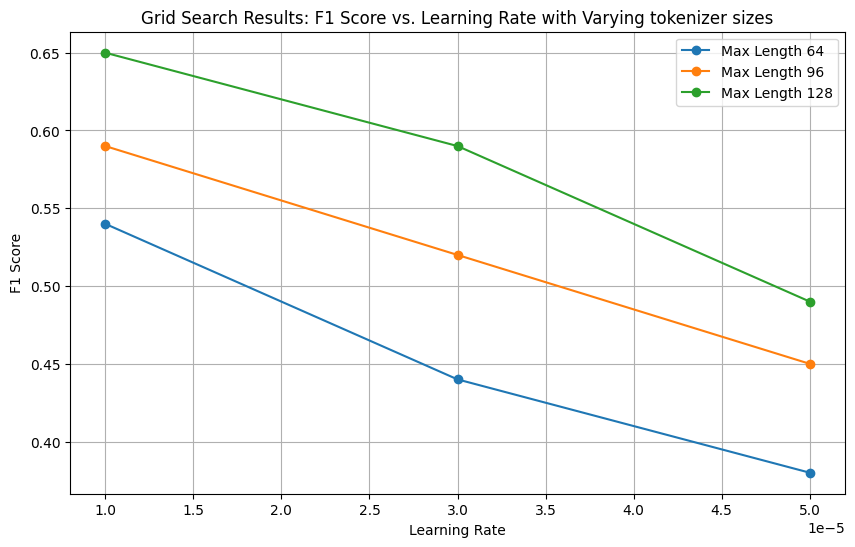

In [37]:
import itertools
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Define hyperparameter grid
max_len_options = [64, 96, 128]
lr_options = [1e-5, 3e-5, 5e-5]

# Store results
results = []

device = "cuda" if torch.cuda.is_available() else "cpu"

def early_stopping(f1_scores, patience=2):
    if len(f1_scores) > patience and all(f1_scores[-patience-1] >= score for score in f1_scores[-patience:]):
        return True
    return False

# Grid search
for max_len, lr in itertools.product(max_len_options, lr_options):
    print(f"Training with max_len={max_len}, lr={lr}")
    
    model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    f1_score = train(model, augmented_train_df, num_epochs=5, lr=lr, optimizer=optimizer, lr_scheduler=lrs, max_len=max_len)
    # Store results
    results.append((max_len, lr, f1_score["f1"]))

# Convert results to a format suitable for plotting
max_lens, lrs, f1_scores = zip(*results)

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(lrs, f1_scores, c=max_lens, cmap='viridis', s=100, alpha=0.75, edgecolors='k')
plt.colorbar(scatter, label='Max Length')
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.title("Grid Search Results: F1 Score vs. Learning Rate")
plt.show()

### Training the Best Model

#### Without Learning Rate Scheduler: F1 - 0.59

In [74]:
# Without Learning Rate Scheduler
model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)

lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr)
results = train(model, augmented_train_df, num_epochs= 2, lr=lr, optimizer=optimizer)

Some weights of DebertaClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['fc.bias', 'fc.weight', 'highway.gate.bias', 'highway.gate.weight', 'highway.transform.bias', 'highway.transform.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.453400
200,0.327800
300,0.244900
400,0.247100
500,0.212100
600,0.189800
700,0.208000
800,0.135500
900,0.144000
1000,0.149300


In [75]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 128)
test_loader = DataLoader(test_dataset, shuffle=True)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2094/2094 [00:42<00:00, 49.63it/s]

              precision    recall  f1-score   support

     Not PCL       0.95      0.97      0.96      1895
         PCL       0.63      0.55      0.59       199

    accuracy                           0.93      2094
   macro avg       0.79      0.76      0.77      2094
weighted avg       0.92      0.93      0.92      2094



#### With Learning Rate Scheduler: F1 - 0.65

In [ ]:
model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)

lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr)
lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
results = train(model, augmented_train_df, num_epochs= 2, lr=lr, optimizer=optimizer, lr_scheduler=lrs)

Some weights of DebertaClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['fc.bias', 'fc.weight', 'highway.gate.bias', 'highway.gate.weight', 'highway.transform.bias', 'highway.transform.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.532200
200,0.399900
300,0.293600
400,0.349300
500,0.293800
600,0.239000
700,0.242800
800,0.184400
900,0.250900
1000,0.202900


In [ ]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 128)
test_loader = DataLoader(test_dataset, shuffle=False)

preds = evaluate(model, tokenizer, test_loader)

file = open("dev.txt","w")
for i in preds:
    file.write(str(i[0])+"\n")

file.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2094/2094 [00:41<00:00, 50.36it/s]

              precision    recall  f1-score   support

     Not PCL       0.97      0.96      0.96      1895
         PCL       0.62      0.67      0.65       199

    accuracy                           0.93      2094
   macro avg       0.79      0.82      0.80      2094
weighted avg       0.93      0.93      0.93      2094



In [32]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(test_df, tokenizer, 128,test_set=True)
test_loader = DataLoader(test_dataset, shuffle=False)


preds = evaluate(model, tokenizer, test_loader,score=False)

file = open("test.txt","w")
for i in preds:
    file.write(str(i)+"\n")

file.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3832/3832 [01:16<00:00, 50.06it/s]


### Best Model without Data Augmentation and Upsampling Minority Class

In [ ]:
# model = JoBert.from_pretrained('FacebookAI/roberta-base').to(device)
model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)

lr = 1e-5
#optimizer = optim.AdamW(model.parameters(), lr)
optimizer = optim.AdamW(model.parameters(), lr)
lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
results = train(model, augmented_train_df, num_epochs= 2, lr=lr, optimizer=optimizer, lr_scheduler=lrs)

In [ ]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 64)
test_loader = DataLoader(test_dataset, shuffle=True)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████| 2094/2094 [01:27<00:00, 23.87it/s]

              precision    recall  f1-score   support

     Not PCL       0.97      0.91      0.94      1895
         PCL       0.47      0.73      0.58       199

    accuracy                           0.90      2094
   macro avg       0.72      0.82      0.76      2094
weighted avg       0.92      0.90      0.91      2094



### Best Model without Data Augmentation

In [ ]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 64)
test_loader = DataLoader(test_dataset, shuffle=True)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████| 2094/2094 [01:31<00:00, 23.01it/s]

              precision    recall  f1-score   support

     Not PCL       0.96      0.95      0.95      1895
         PCL       0.56      0.62      0.59       199

    accuracy                           0.92      2094
   macro avg       0.76      0.79      0.77      2094
weighted avg       0.92      0.92      0.92      2094



### Comparison with Baseline

In [73]:
# Baseline Models
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Sample dataset
X_train = augmented_train_df['text']
y_train = augmented_train_df['label']

X_dev = dev_df['text']
y_dev = dev_df['label']

# Stopwords (can be included or ignored)
stop_words = stopwords.words('english')

# Use TF-IDF Vectorization instead of CountVectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words=stop_words, ngram_range=(1,2))

# Transform the text data into numerical vectors
X_train = vectorizer.fit_transform(X_train)
X_dev = vectorizer.transform(X_dev)

# Define classifiers
rf = RandomForestClassifier(random_state=1)  # Random Forest Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)  # XGBoost

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predict on the development set
rf_pred = rf.predict(X_dev)
xgb_pred = xgb.predict(X_dev)

# Print classification reports
print("Random Forest:\n", classification_report(y_dev, rf_pred, target_names=["Not PCL","PCL"]))
print("XGBoost Classifier:\n", classification_report(y_dev, xgb_pred, target_names=["Not PCL","PCL"]))

/vol/bitbucket/dj623/deep-learning/DL_CW_2_dj623/cw2/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:20:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest:
               precision    recall  f1-score   support

     Not PCL       0.94      0.91      0.92      1895
         PCL       0.31      0.40      0.35       199

    accuracy                           0.86      2094
   macro avg       0.62      0.65      0.64      2094
weighted avg       0.88      0.86      0.87      2094

XGBoost Classifier:
               precision    recall  f1-score   support

     Not PCL       0.96      0.65      0.78      1895
         PCL       0.18      0.75      0.30       199

    accuracy                           0.66      2094
   macro avg       0.57      0.70      0.54      2094
weighted avg       0.89      0.66      0.73      2094



### Model Performance with Text Length

In [54]:
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Define six text size bins (token length)
SIZE_BINS = [0, 30, 60, 90, 120, float('inf')]
SIZE_LABELS = ["XS", "S", "M", "L", "XL"]

def categorize_texts(df, tokenizer):
    categorized_texts = {size: [] for size in SIZE_LABELS}
    
    for _, row in df.iterrows():
        text = row['text']
        tokenized_length = len(tokenizer.tokenize(text))

        # Find the appropriate category
        for i in range(len(SIZE_BINS) - 1):
            if SIZE_BINS[i] <= tokenized_length < SIZE_BINS[i+1]:
                categorized_texts[SIZE_LABELS[i]].append(row)
                break
    
    return {size: pd.DataFrame(categorized_texts[size]).reset_index(drop=True) for size in SIZE_LABELS}

# Categorize dataset
categorized_dfs = categorize_texts(dev_df, tokenizer)

# Store results
misclassification_results = {}

for size, df in categorized_dfs.items():
    if df.empty:
        continue  # Skip empty categories
    
    # Create dataset & dataloader
    dataset = DPMDataset(df, tokenizer, 128)
    loader = DataLoader(dataset, shuffle=False)

    # Evaluate model
    print("Scores for size: ",size)
    preds = evaluate(model, tokenizer, loader)
    
    # True labels
    true_labels = df["label"].astype(int).values

    # Compute misclassification statistics
    misclassified = 0
    total_samples = 0
    for ind in range(len(true_labels)):
        if(true_labels[ind]==1):
            misclassified += true_labels[ind]!=preds[ind][0]
            total_samples += 1
    
    misclassification_rate = misclassified / total_samples

    # Store results
    misclassification_results[size] = {
        "Misclassification Rate": misclassification_rate,
        "Misclassified Values": misclassified,
        "Total PCL True Values": total_samples
    }

# Print results
for size, metrics in misclassification_results.items():
    print(f"Size Category: {size}")
    print(f"  - Misclassification Rate: {metrics['Misclassification Rate']:.4f}")
    print(f"  - Misclassified Values: {metrics['Misclassified Values']}")
    print(f"  - Total PCL True Values: {metrics['Total PCL True Values']}\n")


Scores for size:  XS


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:07<00:00, 51.13it/s]


              precision    recall  f1-score   support

     Not PCL       0.99      0.96      0.97       365
         PCL       0.61      0.88      0.72        26

    accuracy                           0.95       391
   macro avg       0.80      0.92      0.85       391
weighted avg       0.97      0.95      0.96       391

Scores for size:  S


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:20<00:00, 51.79it/s]


              precision    recall  f1-score   support

     Not PCL       0.97      0.97      0.97       973
         PCL       0.65      0.67      0.66        92

    accuracy                           0.94      1065
   macro avg       0.81      0.82      0.82      1065
weighted avg       0.94      0.94      0.94      1065

Scores for size:  M


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 423/423 [00:08<00:00, 51.27it/s]


              precision    recall  f1-score   support

     Not PCL       0.94      0.95      0.94       371
         PCL       0.58      0.54      0.56        52

    accuracy                           0.90       423
   macro avg       0.76      0.74      0.75       423
weighted avg       0.89      0.90      0.89       423

Scores for size:  L


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 50.37it/s]


              precision    recall  f1-score   support

     Not PCL       0.92      0.97      0.94       123
         PCL       0.71      0.50      0.59        20

    accuracy                           0.90       143
   macro avg       0.82      0.73      0.77       143
weighted avg       0.89      0.90      0.89       143

Scores for size:  XL


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 50.39it/s]

              precision    recall  f1-score   support

     Not PCL       0.91      0.95      0.93        63
         PCL       0.50      0.33      0.40         9

    accuracy                           0.88        72
   macro avg       0.70      0.64      0.67        72
weighted avg       0.86      0.88      0.86        72

Size Category: XS
  - Misclassification Rate: 0.1154
  - Misclassified Values: 3
  - Total PCL True Values: 26

Size Category: S
  - Misclassification Rate: 0.3261
  - Misclassified Values: 30
  - Total PCL True Values: 92

Size Category: M
  - Misclassification Rate: 0.4615
  - Misclassified Values: 24
  - Total PCL True Values: 52

Size Category: L
  - Misclassification Rate: 0.5000
  - Misclassified Values: 10
  - Total PCL True Values: 20

Size Category: XL
  - Misclassification Rate: 0.6667
  - Misclassified Values: 6
  - Total PCL True Values: 9



### Model Performance depending on Categories

In [81]:
model = DebertaClassification.from_pretrained('microsoft/deberta-base').to(device)

lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr)
lrs = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
results = train(model, augmented_train_df, num_epochs= 2, lr=lr, optimizer=optimizer, lr_scheduler=lrs)

Some weights of DebertaClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['fc.bias', 'fc.weight', 'highway.gate.bias', 'highway.gate.weight', 'highway.transform.bias', 'highway.transform.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.594000
200,0.408500
300,0.307800
400,0.369900
500,0.315800
600,0.245500
700,0.247600
800,0.181600
900,0.272700
1000,0.226900


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

def compute_f1_per_keyword(preds, dev_df, attribute):
    f1_scores = {}
    recall_scores = {}
    precision_scores = {}

    unique_keywords = dev_df[attribute].unique()

    for keyword in unique_keywords:
        # Filter rows where keyword matches
        keyword_mask = dev_df[attribute] == keyword
        keyword_true_labels = dev_df["label"][keyword_mask].astype(int)  # Convert labels to binary
        keyword_preds = np.array(preds)[keyword_mask]

        # Skip keywords with no samples in preds
        if len(keyword_true_labels) == 0 or len(keyword_preds) == 0:
            continue
        # Compute F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(
            keyword_true_labels, keyword_preds, average="binary", zero_division=0
        )
        f1_scores[keyword] = (f1, precision,recall)
        precision_scores[keyword] = precision
        recall_scores[keyword] = recall

    # Rank keywords by F1 score (descending order)
    ranked_keywords = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)
    recall_keywords = recall_scores.items()
    # ranked_keywords = precision_scores.items()

    print(f"\nRanking of {attribute} by F1 Score:")
    for rank, (keyword, scores) in enumerate(ranked_keywords, 1):
        print(f"Rank {rank}: {attribute} '{keyword}' - F1 Score = {scores[0]:.4f}, precision Score = {scores[1]:.4f}, recall Score = {scores[2]:.4f}")

    return ranked_keywords


In [16]:
model = DebertaClassification.from_pretrained('deberta-finetuned')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

test_dataset = DPMDataset(dev_df, tokenizer, 128)
test_loader = DataLoader(test_dataset, shuffle=False)

preds = evaluate(model, tokenizer, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2094/2094 [00:41<00:00, 51.05it/s]

              precision    recall  f1-score   support

     Not PCL       0.96      0.96      0.96      1895
         PCL       0.63      0.63      0.63       199

    accuracy                           0.93      2094
   macro avg       0.79      0.80      0.80      2094
weighted avg       0.93      0.93      0.93      2094



In [22]:
category_ranking = compute_f1_per_keyword(preds, dev_df, "keyword")


Ranking of keyword by F1 Score:
Rank 1: keyword 'in-need' - F1 Score = 0.7733, precision Score = 0.6905, recall Score = 0.8788
Rank 2: keyword 'immigrant' - F1 Score = 0.7273, precision Score = 1.0000, recall Score = 0.5714
Rank 3: keyword 'poor-families' - F1 Score = 0.6389, precision Score = 0.6765, recall Score = 0.6053
Rank 4: keyword 'disabled' - F1 Score = 0.6364, precision Score = 0.8750, recall Score = 0.5000
Rank 5: keyword 'vulnerable' - F1 Score = 0.6364, precision Score = 0.5833, recall Score = 0.7000
Rank 6: keyword 'migrant' - F1 Score = 0.6000, precision Score = 0.6000, recall Score = 0.6000
Rank 7: keyword 'homeless' - F1 Score = 0.5970, precision Score = 0.5263, recall Score = 0.6897
Rank 8: keyword 'hopeless' - F1 Score = 0.5882, precision Score = 0.6000, recall Score = 0.5769
Rank 9: keyword 'refugee' - F1 Score = 0.5000, precision Score = 0.4667, recall Score = 0.5385
Rank 10: keyword 'women' - F1 Score = 0.4000, precision Score = 0.6667, recall Score = 0.2857


In [23]:
category_ranking = compute_f1_per_keyword(preds, dev_df, "country")


Ranking of country by F1 Score:
Rank 1: country 'hk' - F1 Score = 0.8750, precision Score = 1.0000, recall Score = 0.7778
Rank 2: country 'my' - F1 Score = 0.7778, precision Score = 0.7000, recall Score = 0.8750
Rank 3: country 'nz' - F1 Score = 0.7368, precision Score = 1.0000, recall Score = 0.5833
Rank 4: country 'ie' - F1 Score = 0.7368, precision Score = 0.7778, recall Score = 0.7000
Rank 5: country 'ke' - F1 Score = 0.7333, precision Score = 0.6471, recall Score = 0.8462
Rank 6: country 'ng' - F1 Score = 0.7143, precision Score = 0.7692, recall Score = 0.6667
Rank 7: country 'tz' - F1 Score = 0.7000, precision Score = 0.7778, recall Score = 0.6364
Rank 8: country 'za' - F1 Score = 0.6957, precision Score = 0.6667, recall Score = 0.7273
Rank 9: country 'ca' - F1 Score = 0.6667, precision Score = 0.7143, recall Score = 0.6250
Rank 10: country 'lk' - F1 Score = 0.6667, precision Score = 0.6667, recall Score = 0.6667
Rank 11: country 'pk' - F1 Score = 0.6400, precision Score = 0.727

In [24]:
category_ranking = compute_f1_per_keyword(preds, dev_df, "orig_label")


Ranking of orig_label by F1 Score:
Rank 1: orig_label '4' - F1 Score = 0.8500, precision Score = 1.0000, recall Score = 0.7391
Rank 2: orig_label '3' - F1 Score = 0.7552, precision Score = 1.0000, recall Score = 0.6067
Rank 3: orig_label '2' - F1 Score = 0.3636, precision Score = 1.0000, recall Score = 0.2222
Rank 4: orig_label '0' - F1 Score = 0.0000, precision Score = 0.0000, recall Score = 0.0000
Rank 5: orig_label '1' - F1 Score = 0.0000, precision Score = 0.0000, recall Score = 0.0000
